In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt


%matplotlib inline


sns.set(color_codes=True)

---
## Load data

In [3]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## Modelling



In [4]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### 1. Data sampling



In [5]:

train_df = df.copy()


y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### 2. Model training


In [8]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

### 3. Evaluation



In [9]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [10]:
y_test.value_counts()

churn
0    3286
1     366
Name: count, dtype: int64

In [11]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 17
False positives: 5
True negatives: 3281
False negatives: 349

Accuracy: 0.9030668127053669
Precision: 0.7727272727272727
Recall: 0.04644808743169399


 Within the test set about 10% of the rows are churners (churn = 1).
- Looking at the true negatives, we have 3282 out of 3286. This means that out of all the negative cases (churn = 0), we predicted 3282 as negative (hence the name True negative). This is great!
- Looking at the false negatives, this is where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is quite high at 348, we want to get the false negatives to as close to 0 as we can, so this would need to be addressed when improving the model.
- Looking at false positives, this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 4 cases, which is great!
- With the true positives, we can see that in total we have 366 clients that churned in the test dataset. However, we are only able to correctly identify 18 of those 366, which is very poor.
- Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.
- Looking at the precision score, this shows us a score of 0.82 which is not bad, but could be improved.
- However, the recall shows us that the classifier has a very poor ability to identify positive samples. This would be the main concern for improving this model!

So overall, we're able to very accurately identify clients that do not churn, but we are not able to predict cases where clients do churn! What we are seeing is that a high % of clients are being identified as not churning when they should be identified as churning. This in turn tells us that the current set of features are not discriminative enough to clearly distinguish between churners and non-churners. 

##### Model understanding

Let's check the feature importance before further fine-tuning of the model

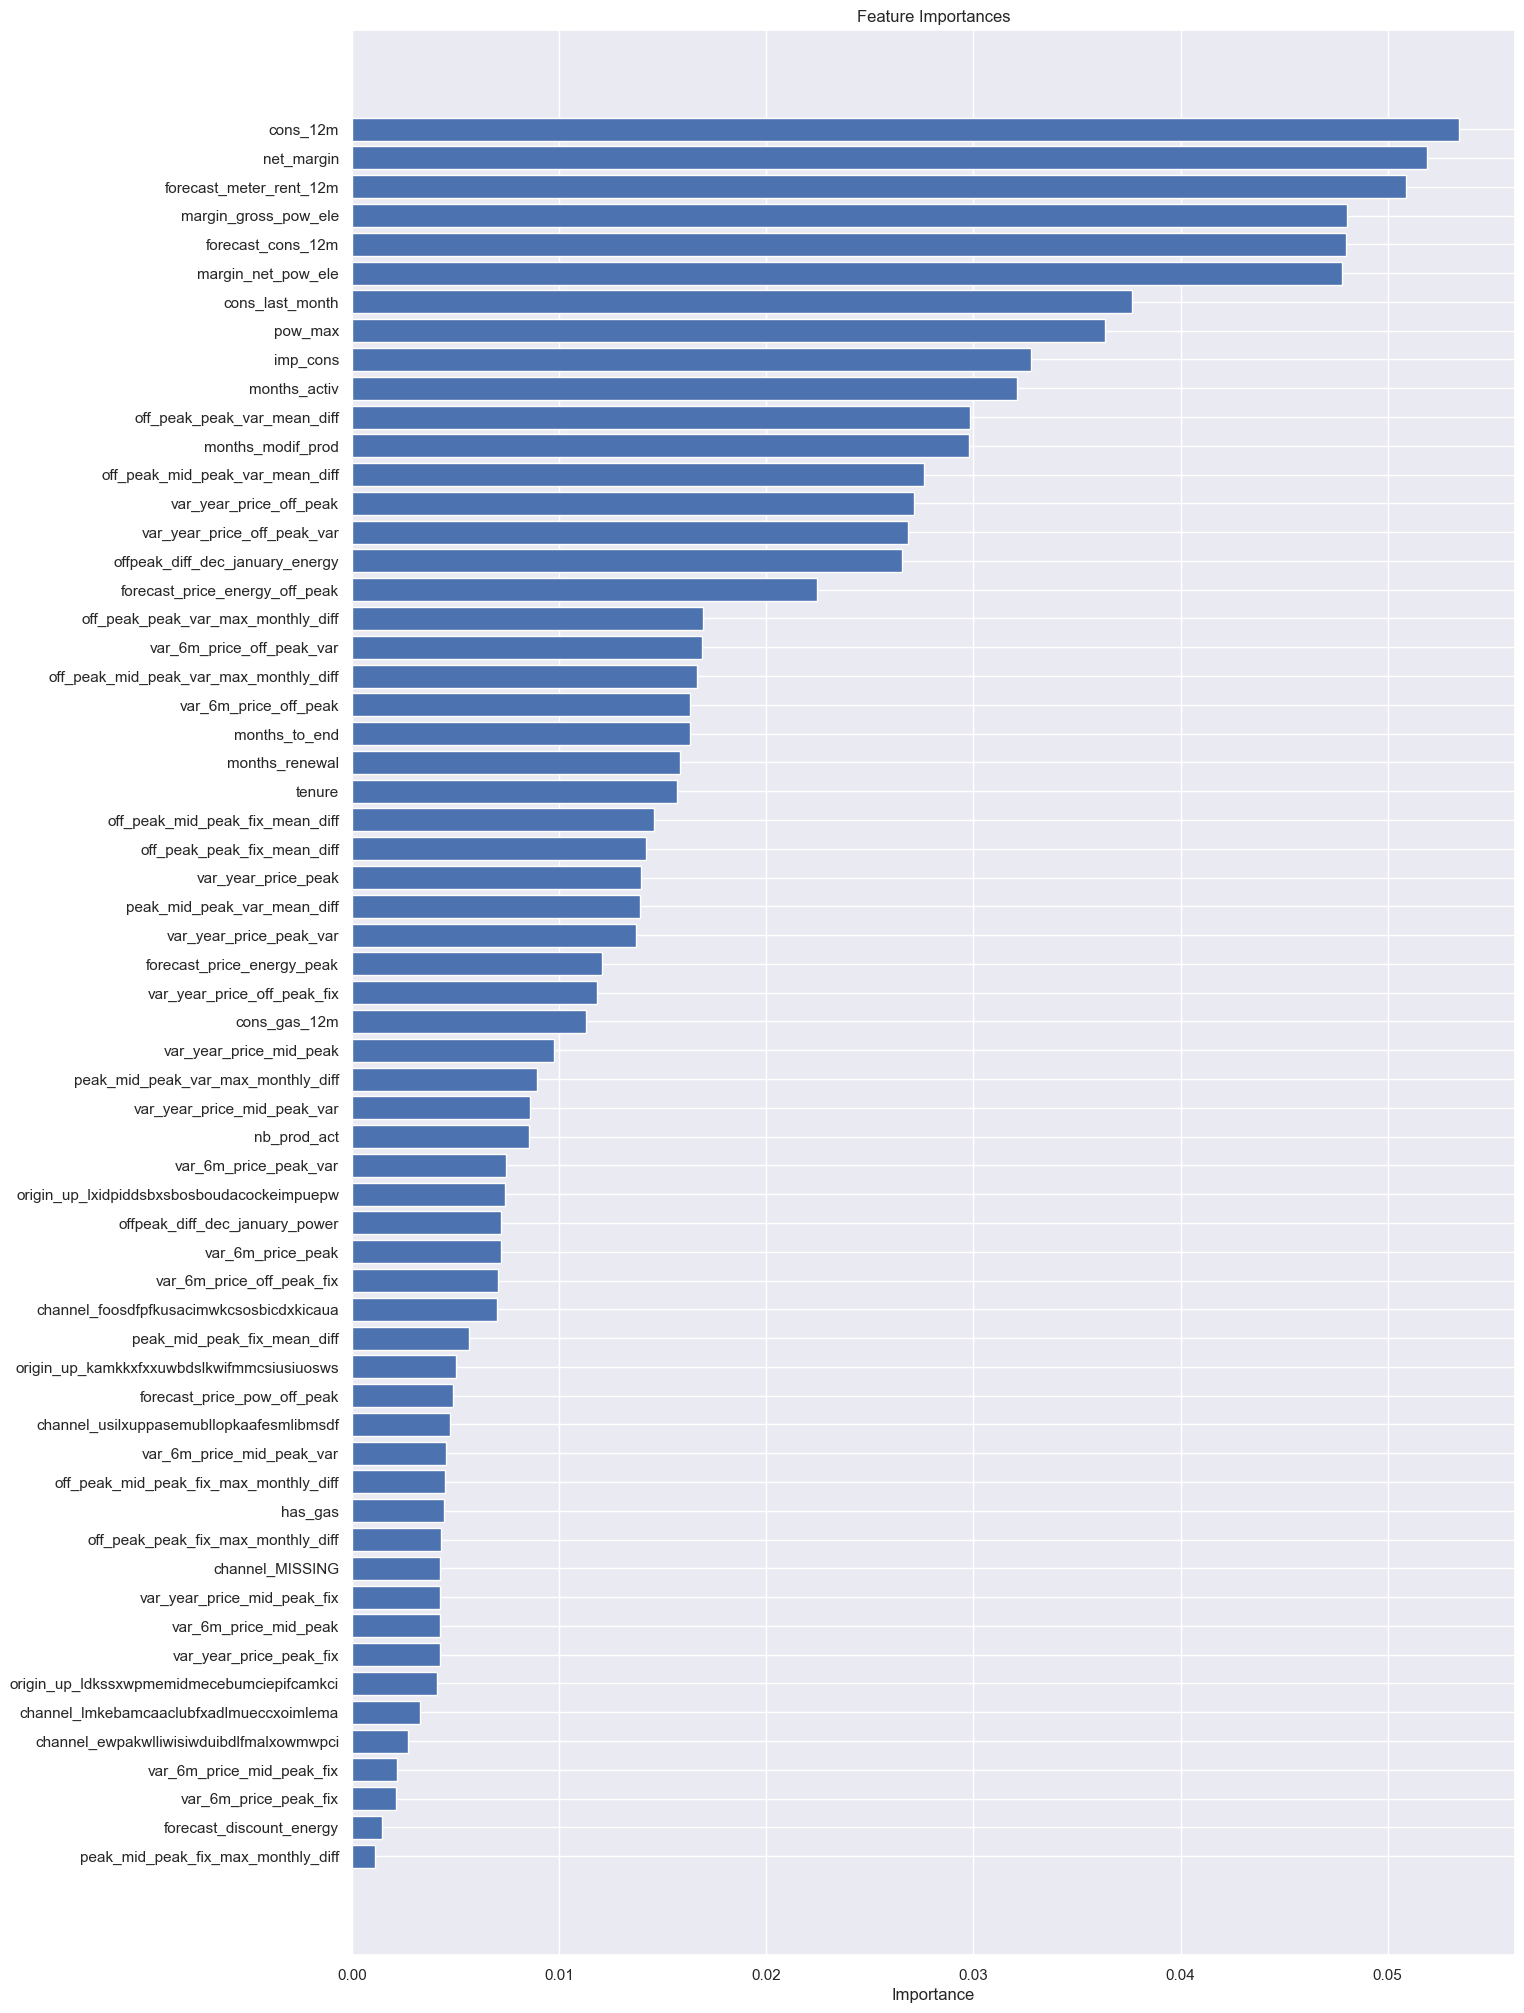

In [17]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

By the above graph we conclude that price senstivity is a weak contributor thus disproving our original hypothesis 
> Is churn driven by the customers' price sensitivity?

In [15]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')